## With this Notebook I want to compute all the relevant metrics for all the images computed for the different align methods

In [1]:
import torch
from PIL import Image
import wandb
import torchmetrics
from torchvision.models import alexnet, inception_v3
import json
import os
from os.path import join as opj
from torchvision.transforms import *
import numpy as np
from scipy import signal
import tqdm
from torchsummary import summary
import torchextractor as tx
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
import clip
from torchmetrics.image.fid import FrechetInceptionDistance
import pandas as pd
import matplotlib.pyplot as plt
import pickle

/home/matteo/anaconda3/envs/braindiff/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
target_run="eager-river-4" 

api=wandb.Api()
project=api.project("BrainDecodingNSD_MNI")

entity, project = "matteoferrante", "BrainDecodingNSD_MNI"  # set to your entity and project
runs = api.runs(entity + "/" + project)

In [3]:
method="ridge"
fraction=100
version="v1"

In [4]:
def get_data(method,fraction,version):
    active_run=None
    for run in api.runs(project):
        if run.name==target_run:
            print(f"found {target_run}")
            active_run=target_run

            for artifact in run.logged_artifacts():
                artifact_path = artifact.download()

                if f"table_{method}_{fraction}:{version}" in artifact_path:
                    decoded_artifact=artifact_path
                    f=open(f"{artifact_path}/table_{method}_{fraction}.table.json")
                    meta = json.load(f)
                    data=meta["data"]
                    shown=[]
                    subj01=[]
                    subj02=[]
                    subj05=[]
                    subj07=[]
                    for i in range(len(data)):
                        shown.append(data[i][0]["path"])
                        subj01.append(data[i][1]["path"])
                        subj02.append(data[i][2]["path"])
                        subj05.append(data[i][3]["path"])
                        subj07.append(data[i][4]["path"])

                        # gen=[]
                        # for j in range(1,len(data[i])):
                        #     gen.append(data[i][j]["path"])
                        # generated.append(gen)
                    print(artifact_path)
                    break
            
    return shown,subj01,subj02,subj05,subj07,decoded_artifact
            
            
        

In [5]:
# shown_imgs=[Image.open(opj(decoded_artifact,i)).convert("RGB") for i in shown]
# subj01_imgs=[Image.open(opj(decoded_artifact,i)).convert("RGB") for i in subj01]
# subj02_imgs=[Image.open(opj(decoded_artifact,i)) for i in subj02]
# subj05_imgs=[Image.open(opj(decoded_artifact,i)) for i in subj05]
# subj07_imgs=[Image.open(opj(decoded_artifact,i)) for i in subj07]


## Metrics for Ridge

In [6]:
base_transform=Compose([Resize(425),ToTensor()])


def compute_pixcorr(shown_imgs, generated_imgs):
    pix_corr=[]
    for x,y in tqdm.tqdm(list(zip(shown_imgs,generated_imgs))):
        x=base_transform(x).numpy()
        y=base_transform(y).numpy()
        pc= np.abs(np.corrcoef(x.flatten(), y.flatten())[0][1])
        pix_corr.append(pc)
    return np.mean(pix_corr)


def ssim(shown_imgs,generated_imgs):
    ssim_metric=torchmetrics.StructuralSimilarityIndexMeasure()
    x_torch=[base_transform(i) for i in shown_imgs]
    y_torch=[base_transform(i) for i in generated_imgs]
    
    x_torch=torch.stack(x_torch)
    y_torch=torch.stack(y_torch)
    ssim=ssim_metric(x_torch,y_torch)
    
    return ssim

def n_way_acc(x,y,model,n=2,device="cpu",transforms=None):
    
    
    model.to(device)
    cosine=torch.nn.CosineSimilarity()
    acc=0
    
    ## transform all images
    
    x_torch=torch.stack([transforms(i) for i in x])
    y_torch=torch.stack([transforms(i) for i in y])
    
    
    with torch.no_grad():
        for i in tqdm.tqdm(range(len(x))):
            
            
            
            original_features=model(x_torch[i].unsqueeze(0).to(device)).cpu()
            generated_features=model(y_torch[i].unsqueeze(0).to(device)).cpu()

            rnd_idx=torch.randint(len(x),(1,)).item()

            random_features=model(y_torch[rnd_idx].unsqueeze(0).to(device)).cpu()

            gen_dist=cosine(original_features.reshape(len(original_features),-1),generated_features.reshape(len(generated_features),-1))
            rnd_dist=cosine(original_features.reshape(len(original_features),-1),random_features.reshape(len(random_features),-1))
            if gen_dist>=rnd_dist:
                acc+=1
    return acc/len(x)

In [7]:
def n_way_acc_clip(x,y,model,n=2,device="cpu",preprocess=None):
    
    cosine=torch.nn.CosineSimilarity()
    acc=0
    with torch.no_grad():
        for i in tqdm.tqdm(range(len(x))):
            
            orig_image = preprocess(x[i]).unsqueeze(0).to(device)
            
            gen_image = preprocess(y[i]).unsqueeze(0).to(device)
            
            rnd_idx=torch.randint(len(x),(1,)).item()
            rnd_image = preprocess(y[rnd_idx]).unsqueeze(0).to(device)
            
            
            
            original_features=model.encode_image(orig_image).cpu().double()
            generated_features=model.encode_image(gen_image).cpu().double()


            random_features=model.encode_image(rnd_image).cpu().double()


            gen_dist=cosine(original_features.reshape(len(original_features),-1),generated_features.reshape(len(generated_features),-1))
            rnd_dist=cosine(original_features.reshape(len(original_features),-1),random_features.reshape(len(random_features),-1))
            if gen_dist>=rnd_dist:
                acc+=1
    return acc/len(x)

In [8]:
           
    

# x_torch_alexnet=torch.stack([alexnet_transforms(i) for i in shown_imgs])
# y_torch_alexnet=torch.stack([alexnet_transforms(i) for i in first_candidates])

In [9]:
def compute_metrics(shown_imgs,gen_imgs,device="cpu"):
    
    ##models
    
    alexnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
    alexnet_model.eval()


    alexnet_transforms=Compose([transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


    inception_transforms=Compose([transforms.Resize(342),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


    modules_2=list(alexnet_model.children())[0][:3]
    modules_5=list(alexnet_model.children())[0][:10]
    alexnet_model_2=torch.nn.Sequential(*modules_2)
    alexnet_model_5=torch.nn.Sequential(*modules_5)

    inception_model=inception_v3(pretrained=True)

    inception_model.fc = torch.nn.Identity()
    inception_model.eval()
    print() 
    
    clip_model, preprocess = clip.load("ViT-B/32", device=device)
    
    ##metrics
    
    pix_corr=compute_pixcorr(shown_imgs,gen_imgs)
    ssim_score=ssim(shown_imgs,gen_imgs)
    alex2=n_way_acc(shown_imgs,gen_imgs,alexnet_model_2,device=device,transforms=alexnet_transforms)
    alex5=n_way_acc(shown_imgs,gen_imgs,alexnet_model_5,device=device,transforms=alexnet_transforms)
    inception=n_way_acc(shown_imgs,gen_imgs,inception_model,device=device,transforms=inception_transforms)
    clip_acc=n_way_acc_clip(shown_imgs,gen_imgs,clip_model,device=device,preprocess=preprocess)
    
    return [pix_corr,ssim_score.item(),alex2,alex5,inception,clip_acc]
    

In [10]:
# subj01_metrics=compute_metrics(shown_imgs,subj01_imgs,device="cuda:2")

In [11]:
metrics={"subj01":{"ridge": {100: [], 50: [], 25: [], 10: [] },
                   "anat" : {10: []},
                   "hyper": {100: [], 50: [], 25: [], 10: [] }},
         "subj02":{"ridge": {100: [], 50: [], 25: [], 10: [] },
                   "anat" : {10: []},
                   "hyper": {100: [], 50: [], 25: [], 10: [] }},
         "subj05":{"ridge": {100: [], 50: [], 25: [], 10: [] },
                   "anat" : {10: []},
                   "hyper": {100: [], 50: [], 25: [], 10: [] }},
         "subj07":{"ridge": {100: [], 50: [], 25: [], 10: [] },
                   "anat" : {10: []},
                   "hyper": {100: [], 50: [], 25: [], 10: [] }},
         
                   
        
        }

for method in ["ridge","hyper","anat"]:
    for fraction in metrics["subj01"][method].keys():
    
        if method=="ridge" and fraction==100:
            version="v1"
        else:
            version="v0"
        shown,subj01,subj02,subj05,subj07,decoded_artifact=get_data(method,fraction,version)
        for sub_name,sub in zip(["subj01","subj02","subj05","subj07"],[subj01,subj02,subj05,subj07]):
            print(sub_name,method,fraction)
            shown_imgs=[Image.open(opj(decoded_artifact,i)).convert("RGB") for i in shown]
            subj_imgs=[Image.open(opj(decoded_artifact,i)).convert("RGB") for i in sub]
            metrics[sub_name][method][fraction]= compute_metrics(shown_imgs,subj_imgs,device="cuda:2")



found eager-river-4


wandb:   21 of 21 files downloaded.  
wandb:   21 of 21 files downloaded.  
wandb:   41 of 41 files downloaded.  
wandb: Downloading large artifact run-59s9cbrb-table_ridge_100:v1, 1669.57MB. 4911 files... 
wandb:   4911 of 4911 files downloaded.  
Done. 0:0:1.8


./artifacts/run-59s9cbrb-table_ridge_100:v1
subj01 ridge 100


Using cache found in /home/matteo/.cache/torch/hub/pytorch_vision_v0.10.0
/home/matteo/anaconda3/envs/braindiff/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/matteo/anaconda3/envs/braindiff/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/matteo/anaconda3/envs/braindiff/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent t

100%|█████████████████████████████████████████| 982/982 [00:35<00:00, 27.35it/s]


subj02 ridge 100


Using cache found in /home/matteo/.cache/torch/hub/pytorch_vision_v0.10.0


100%|█████████████████████████████████████████| 982/982 [00:30<00:00, 32.27it/s]


subj05 ridge 100


Using cache found in /home/matteo/.cache/torch/hub/pytorch_vision_v0.10.0


100%|█████████████████████████████████████████| 982/982 [00:30<00:00, 32.01it/s]


subj07 ridge 100


Using cache found in /home/matteo/.cache/torch/hub/pytorch_vision_v0.10.0


100%|█████████████████████████████████████████| 982/982 [00:31<00:00, 30.98it/s]


found eager-river-4


wandb:   21 of 21 files downloaded.  
wandb:   21 of 21 files downloaded.  
wandb:   41 of 41 files downloaded.  
wandb: Downloading large artifact run-59s9cbrb-table_ridge_100:v1, 1669.57MB. 4911 files... 
wandb:   4911 of 4911 files downloaded.  
Done. 0:0:0.9
wandb: Downloading large artifact run-59s9cbrb-table_ridge_50:v0, 1657.90MB. 4911 files... 
wandb:   4911 of 4911 files downloaded.  
Done. 0:0:4.1


./artifacts/run-59s9cbrb-table_ridge_50:v0
subj01 ridge 50


Using cache found in /home/matteo/.cache/torch/hub/pytorch_vision_v0.10.0


100%|█████████████████████████████████████████| 982/982 [00:33<00:00, 29.08it/s]


subj02 ridge 50


Using cache found in /home/matteo/.cache/torch/hub/pytorch_vision_v0.10.0


100%|█████████████████████████████████████████| 982/982 [00:31<00:00, 31.01it/s]


subj05 ridge 50


Using cache found in /home/matteo/.cache/torch/hub/pytorch_vision_v0.10.0


100%|█████████████████████████████████████████| 982/982 [00:31<00:00, 31.54it/s]


subj07 ridge 50


Using cache found in /home/matteo/.cache/torch/hub/pytorch_vision_v0.10.0


100%|█████████████████████████████████████████| 982/982 [00:32<00:00, 29.81it/s]


found eager-river-4


wandb:   21 of 21 files downloaded.  
wandb:   21 of 21 files downloaded.  
wandb:   41 of 41 files downloaded.  
wandb: Downloading large artifact run-59s9cbrb-table_ridge_100:v1, 1669.57MB. 4911 files... 
wandb:   4911 of 4911 files downloaded.  
Done. 0:0:0.9
wandb: Downloading large artifact run-59s9cbrb-table_ridge_50:v0, 1657.90MB. 4911 files... 
wandb:   4911 of 4911 files downloaded.  
Done. 0:0:0.9
wandb: Downloading large artifact run-59s9cbrb-table_ridge_25:v0, 1649.79MB. 4911 files... 
wandb:   4911 of 4911 files downloaded.  
Done. 0:0:4.1


./artifacts/run-59s9cbrb-table_ridge_25:v0
subj01 ridge 25


Using cache found in /home/matteo/.cache/torch/hub/pytorch_vision_v0.10.0


100%|█████████████████████████████████████████| 982/982 [00:34<00:00, 28.25it/s]


subj02 anat 10


Using cache found in /home/matteo/.cache/torch/hub/pytorch_vision_v0.10.0


100%|█████████████████████████████████████████| 982/982 [00:30<00:00, 32.17it/s]


subj05 anat 10


Using cache found in /home/matteo/.cache/torch/hub/pytorch_vision_v0.10.0


100%|█████████████████████████████████████████| 982/982 [00:34<00:00, 28.30it/s]


subj07 anat 10


Using cache found in /home/matteo/.cache/torch/hub/pytorch_vision_v0.10.0


100%|█████████████████████████████████████████| 982/982 [00:44<00:00, 22.10it/s]


In [12]:
metrics["subj01"][method].keys()

dict_keys([10])

In [13]:
metrics

{'subj01': {'ridge': {100: [0.2876757486217525,
    0.2681344449520111,
    0.8472505091649695,
    0.9633401221995926,
    0.8961303462321792,
    0.9368635437881874],
   50: [0.28884210126856635,
    0.2678889036178589,
    0.845213849287169,
    0.960285132382892,
    0.9073319755600815,
    0.9429735234215886],
   25: [0.28872577134597177,
    0.2685271203517914,
    0.8492871690427699,
    0.960285132382892,
    0.9022403258655805,
    0.9460285132382892],
   10: [0.2873925456361009,
    0.268315851688385,
    0.8472505091649695,
    0.9663951120162932,
    0.9205702647657841,
    0.9460285132382892]},
  'anat': {10: [0.28687712824614126,
    0.2679815888404846,
    0.8533604887983707,
    0.9623217922606925,
    0.8971486761710794,
    0.955193482688391]},
  'hyper': {100: [0.2863068697070344,
    0.267689973115921,
    0.845213849287169,
    0.9572301425661914,
    0.8930753564154786,
    0.9501018329938901],
   50: [0.28606812641908064,
    0.2683436870574951,
    0.85336048879

In [14]:
with open("metrics.sav","wb") as f:
    pickle.dump(metrics,f)

In [15]:
952/10

95.2

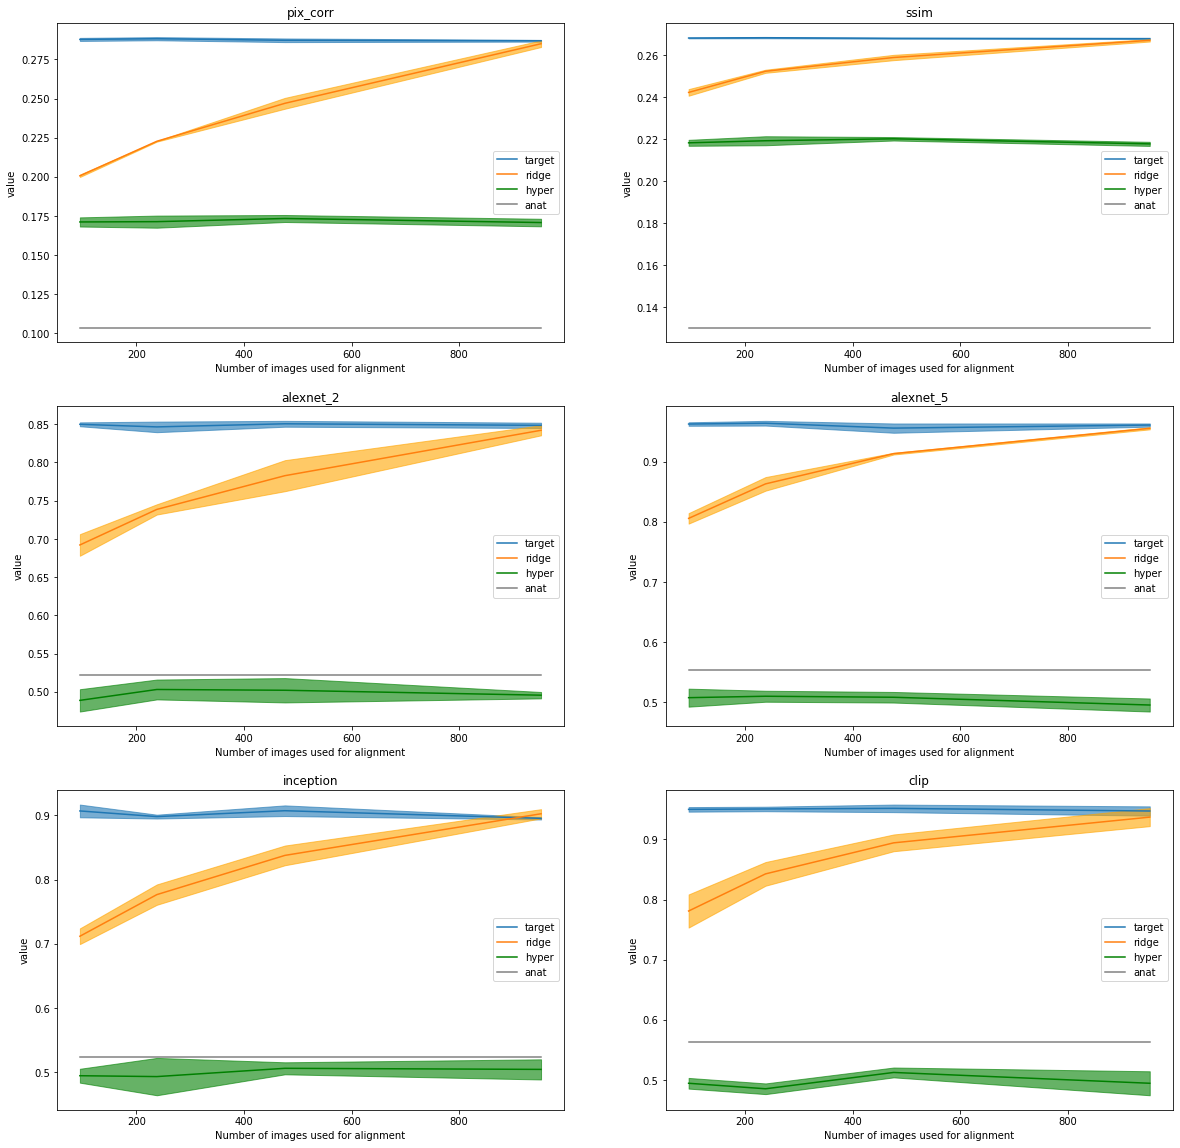

In [16]:
fig,axs=plt.subplots(3,2,figsize=(20,20))
metric_names=["pix_corr","ssim","alexnet_2","alexnet_5","inception","clip"]

fractions=[95, 238 ,476,952]

for i, ax in enumerate(axs.ravel()):
    ax.set_title(metric_names[i])
    
    target=np.stack([[metrics["subj01"]["ridge"][f][i] for f in [10,25,50,100]],[metrics["subj01"]["anat"][f][i] for f in [10]*4],[metrics["subj01"]["hyper"][f][i] for f in [10,25,50,100]]])
    target_mean=target.mean(0)
    target_std=target.std(0)

    # ax.plot([10,25,50,100],[metrics["subj01"]["ridge"][f][i] for f in [10,25,50,100]],label="target_subj")
    ax.plot(fractions,target_mean,color="tab:blue",label="target")
    ax.fill_between(fractions,target_mean+target_std,target_mean-target_std,alpha=0.6,color="tab:blue")

    
    others_ridge=np.stack([[metrics["subj02"]["ridge"][f][i] for f in [10,25,50,100]],[metrics["subj05"]["ridge"][f][i] for f in [10,25,50,100]],[metrics["subj07"]["ridge"][f][i] for f in [10,25,50,100]]])
    others_ridge_mean=others_ridge.mean(0)
    
    others_hyper=np.stack([[metrics["subj02"]["hyper"][f][i] for f in [10,25,50,100]],[metrics["subj05"]["hyper"][f][i] for f in [10,25,50,100]],[metrics["subj07"]["hyper"][f][i] for f in [10,25,50,100]]])
    others_hyper_mean=others_hyper.mean(0)
    
    others_anat=np.stack([[metrics["subj02"]["anat"][f][i] for f in [10]*4],[metrics["subj05"]["anat"][f][i] for f in [10]*4],[metrics["subj07"]["anat"][f][i] for f in [10]*4]])
    others_anat_mean=others_anat.mean(0)
    
    
    ax.plot(fractions,others_ridge_mean,label="ridge",color="tab:orange")
    ax.fill_between(fractions,others_ridge_mean+others_ridge.std(0),others_ridge_mean-others_ridge.std(0),alpha=0.6,color="orange")
    
    ax.plot(fractions,others_hyper_mean,label="hyper",color="green")
    ax.fill_between(fractions,others_hyper_mean+others_hyper.std(0),others_hyper_mean-others_hyper.std(0),alpha=0.6,color="green")
    
    ax.plot(fractions,others_anat_mean,label="anat",color="gray")
    # ax.fill_between([10,25,50,100],others_anat_mean+others_anat.std(0),others_anat_mean-others_anat.std(0),alpha=0.6,color="yellow")
    ax.legend()
    
    ax.set_xlabel("Number of images used for alignment")
    ax.set_ylabel("value")

    
    
plt.legend()
# plt.plot([10,25,50,100],[metrics["subj07"]["ridge"][f][5] for f in [10,25,50,100]])

In [17]:
fig.savefigfig("plots")